# NeuralEE on RETINA Dataset

`RETINA` Dataset includes 27,499 mouse retinal bipolar neurons. Cluster annotation is from 15 cell-types from the original paper.

In [1]:
import random
import numpy as np
import torch

from neuralee.embedding import NeuralEE
from neuralee.dataset import RetinaDataset 
from neuralee._aux import scatter

%matplotlib inline

Choose a GPU if a GPU available. It could be defined as follow:
```
device = torch.device('cuda:0')
device = torch.device('cuda:1')
device = torch.device('cpu')
```

In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

To reproduce the following results, fix the random seed.

In [3]:
torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)

First, we apply log(1 + x) transformation to each element of the cell-gene expression matrix. 
Then, We retain top 500 genes ordered by variance. 
Finally, we normalize the expression of each gene by subtracting its mean and dividing its standard deviation.

In [4]:
retina_dataset = RetinaDataset(save_path='../')
retina_dataset.log_shift()
retina_dataset.subsample_genes(500)  
retina_dataset.standardscale()

File ../retina.loom already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 13166 to 500 genes


We apply NeuralEE with different hyper-paramters.
`N_small` takes from {1.0, 0.5, 0.25}, while `N_smalls`= 1.0 means not applied with stochastic optimization.
`lam` takes from {1, 10}.
`perplexity` fixs as 30.

Compute affinity, perplexity=30.0, on entire dataset
Compute affinity, perplexity=30.0, N_small=19829, on each batch
Neural Elastic Embedding, lambda=1, completed in 68.29s.
Neural Elastic Embedding, lambda=10, completed in 66.41s.
Compute affinity, perplexity=30.0, N_small=9914, on each batch
Neural Elastic Embedding, lambda=1, completed in 33.10s.
Neural Elastic Embedding, lambda=10, completed in 33.15s.
Compute affinity, perplexity=30.0, N_small=4957, on each batch
Neural Elastic Embedding, lambda=1, completed in 19.10s.
Neural Elastic Embedding, lambda=10, completed in 19.06s.


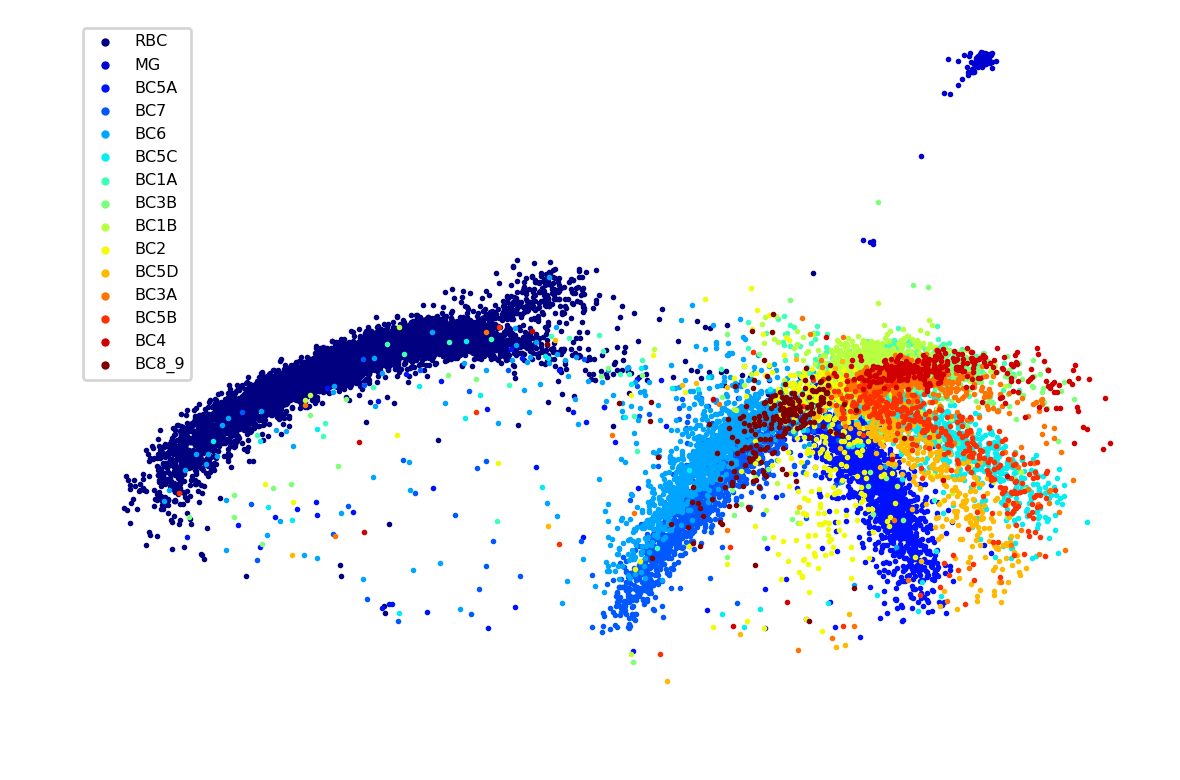

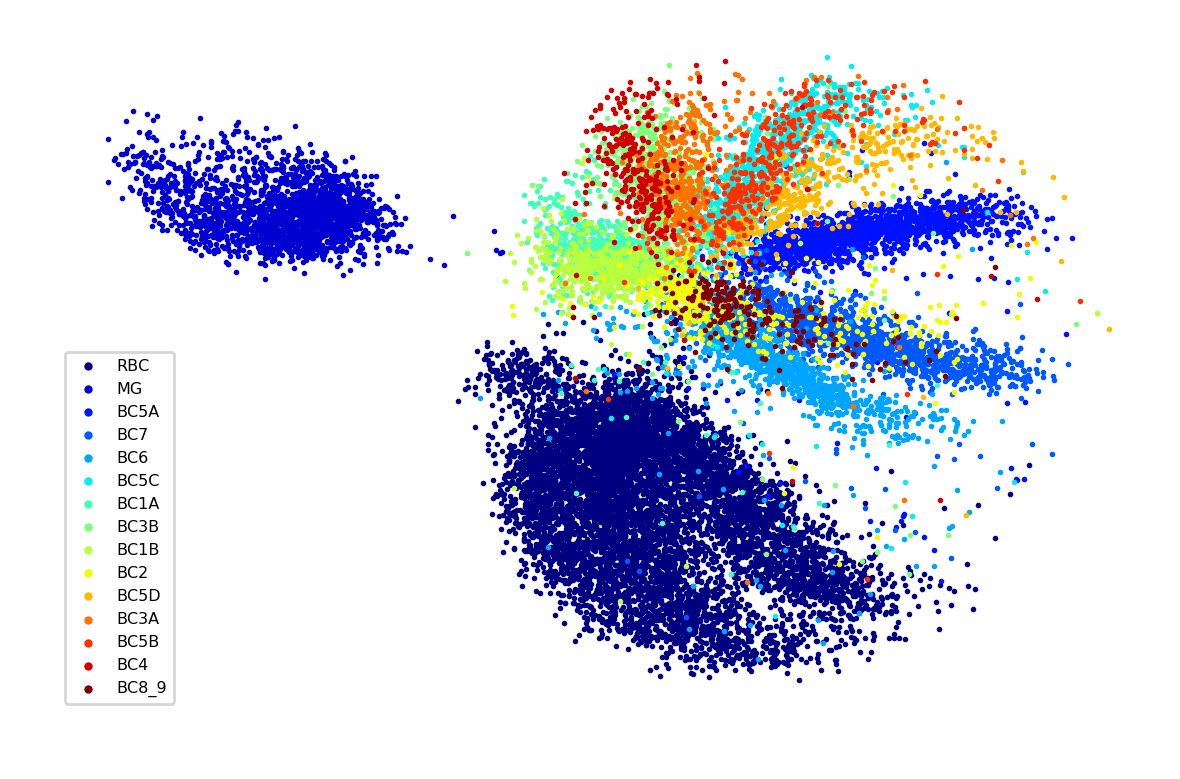

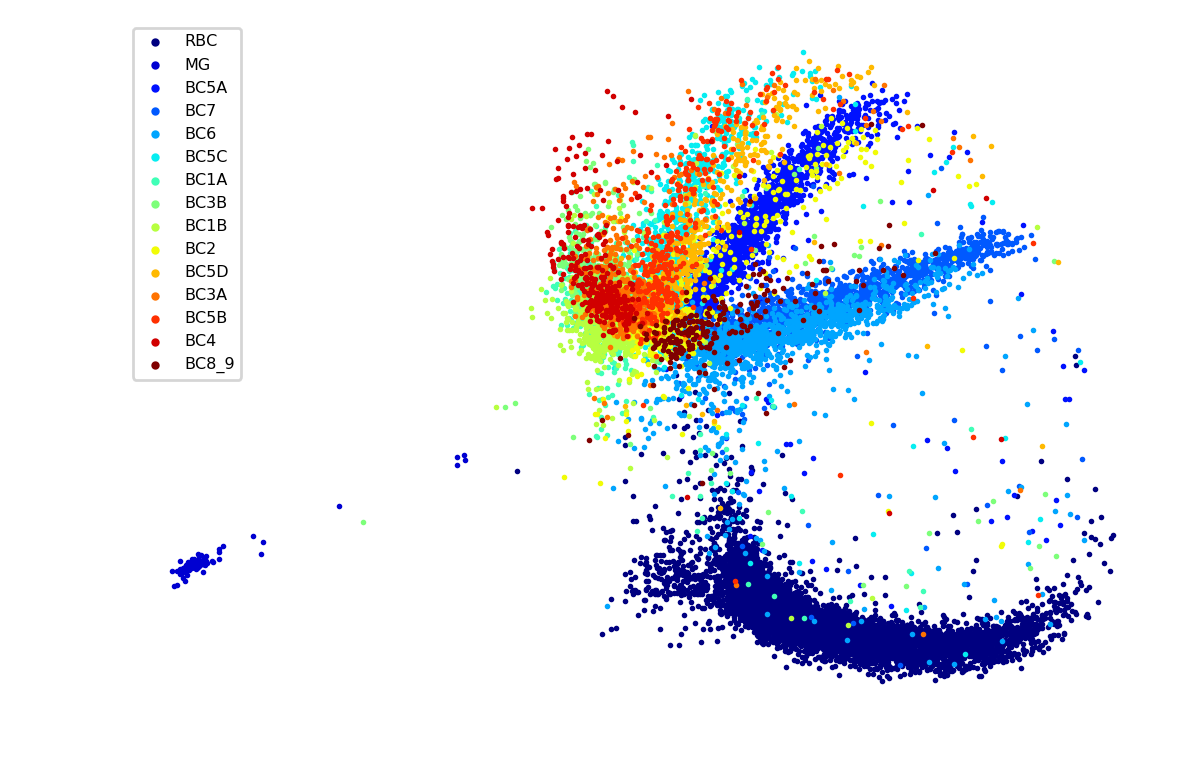

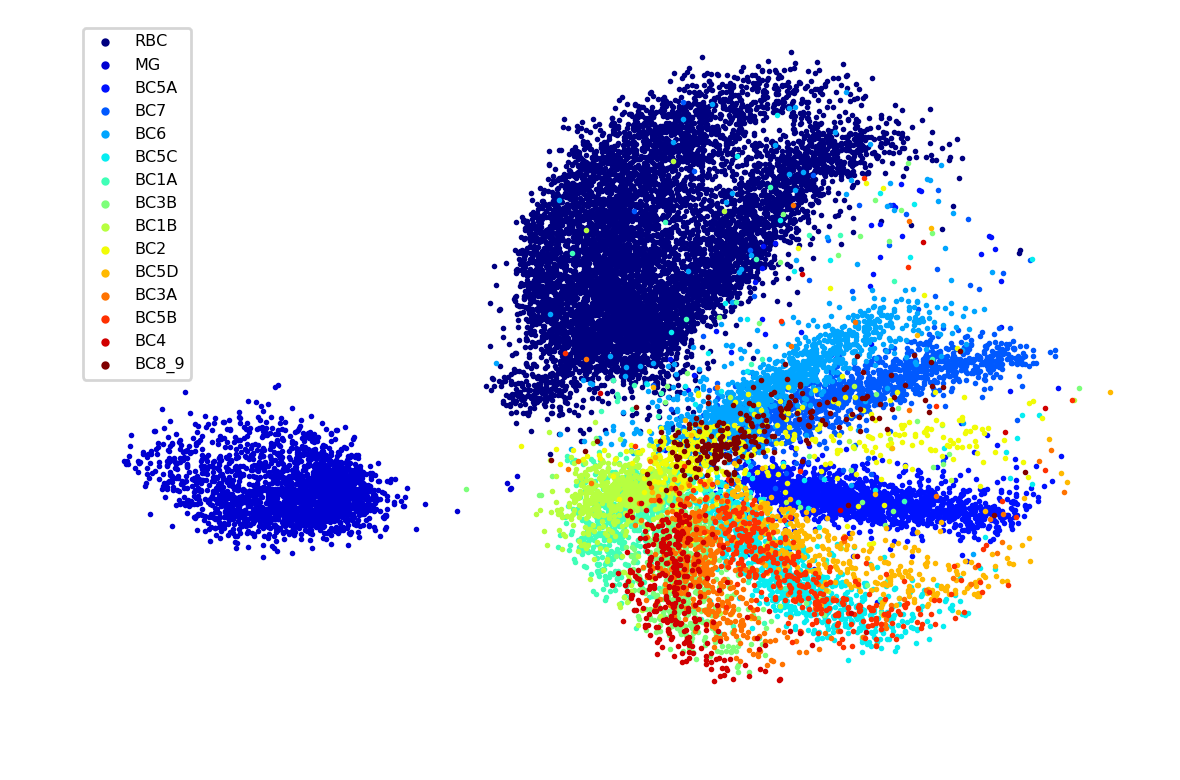

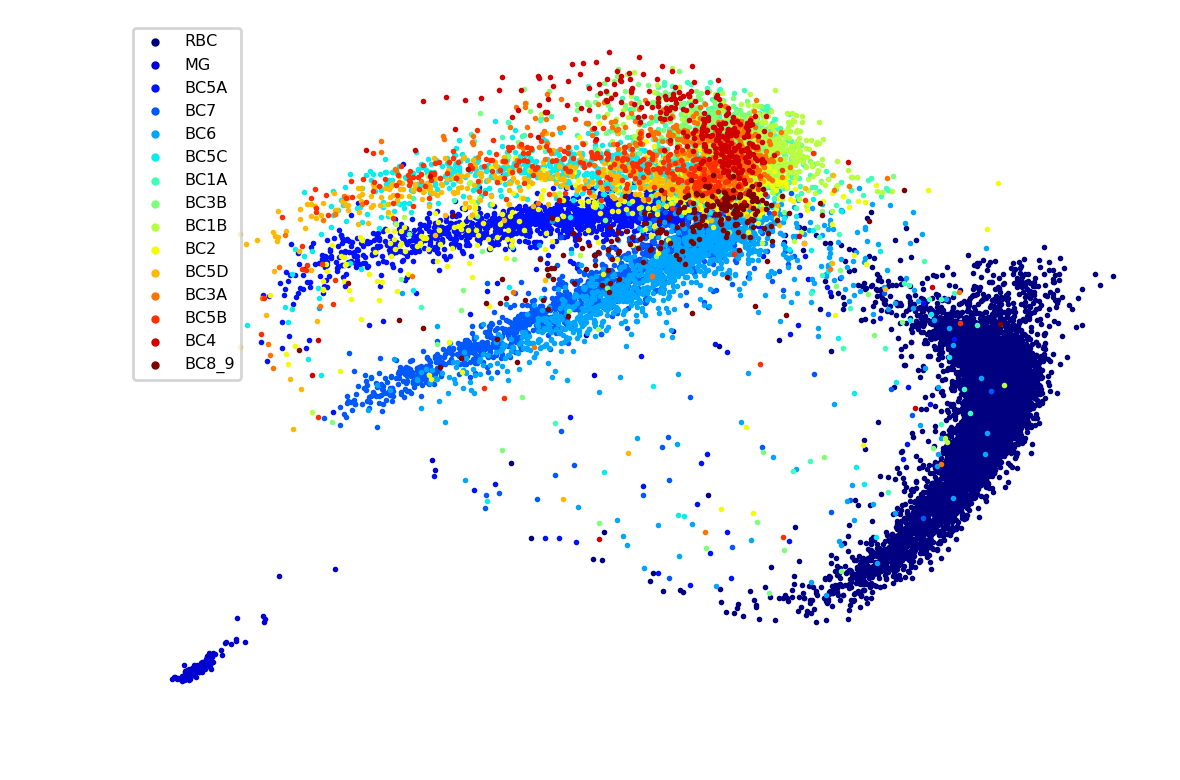

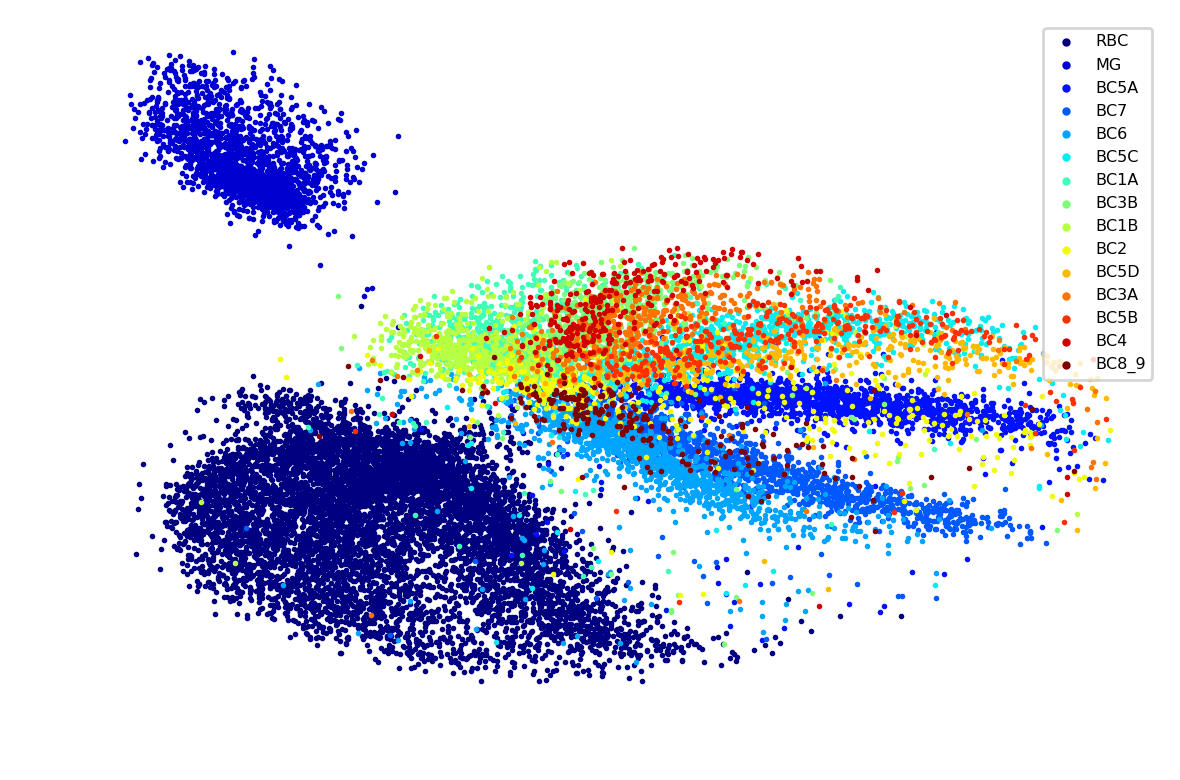

In [5]:
#N_small=1.0, 11G ram of GPU needed.
N_smalls = [1.0, 0.5, 0.25]
N_str = ["nobatch", "2batches", "4batches"]
lams = [1, 10]

retina_dataset.affinity(perplexity=30.0)
for i in range(len(N_smalls)):
    retina_dataset.affinity_split(N_small=N_smalls[i], perplexity=30.0)
    for lam in lams:
        NEE = NeuralEE(retina_dataset, lam=lam, device=device)
        results_Neural = NEE.fine_tune()
        np.save('embedding/RETINA_' + 'lam' + str(lam) + '_' + N_str[i], results_Neural['X'].numpy())
        scatter(results_Neural['X'].numpy(), NEE.labels, 
                retina_dataset.cell_types)